[View in Colaboratory](https://colab.research.google.com/github/pigiipanku/Mewtwo_Freeza/blob/master/Mewtwo_Freeza.ipynb)

In [1]:
#必要なファイルをダウンロード

#model weight
!wget "https://www.dropbox.com/s/b24m53a6x7zlb5e/model.json?dl=1" -nc -O ./model.json
!wget "https://www.dropbox.com/s/rzkk1gabm6ltvl8/weight.h5?dl=1" -nc -O ./weight.h5
!wget "https://www.dropbox.com/s/jah7hzm1eze7zgd/train.zip?dl=1" -nc -O ./train.zip

import os

if not os.path.exists('./train'):
  !unzip train.zip

File ‘./model.json’ already there; not retrieving.
File ‘./weight.h5’ already there; not retrieving.
File ‘./train.zip’ already there; not retrieving.


In [2]:
#必要なライブラリをインポート

import os
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


##ミュウツーvsフリーザ
ディープラーニングでミュウツーとフリーザを画像認識していきます。

###ミュウツー(ポケモン)
![ミュウツー](https://www.dropbox.com/s/513apwjec943lmk/150.gif?dl=1)
###フリーザ（DRAGON BALL)
![代替テキスト](https://www.dropbox.com/s/boxy5zx754g68fh/%E3%83%95%E3%83%AA%E3%83%BC%E3%82%B6_%E3%83%89%E3%83%A9%E3%82%B4%E3%83%B3%E3%83%9C%E3%83%BC%E3%83%AB%E3%83%95%E3%82%A1%E3%82%A4%E3%82%BF%E3%83%BC%E3%82%BA.png?dl=1)


画像認識は、

**ミュウツー**の画像が与えられれば、その画像に写っているのは**ミュウツー**と、

**フリーザ**の画像が与えられれば、その画像に写っているのは**フリーザ**と判断することです。


ディープラーニング（Deep Newral Network)を使って画像認識器を構築していきます。ディープラーニングのなかでも画像の処理を得意とする**Convolutional Neural Network**(以下CNN)を使います。

今回は、なにかとよく似ていると言われがちな**ミュウツー**と**フリーザ**の画像認識器を構築していきます。










##画像認識

###なんでコンピュータは画像認識ごときもできなかったの？

私達、人間にとっては画像認識は簡単です。**ミュウツー**と**フリーザ**なんて１秒もかからずに見分けることができるでしょう。私達は画像認識なんかよりも、素因数分解のほうがよっぽど大変です。


では、なぜ画像認識をコンピュータで行うことが難しい理由を考えてみましょう。そもそも、コンピュータに画像はどのようにみえているのでしょうか？コンピュータにとって画像とは、輝度値（0~255の値）またはRGB値(赤・緑・青の割合を0~255で表した値)　が二次元に並んだデータです。

では、ある画像の輝度値を二次元に並べ、グラフで表示した図を下に示します。このグラフからなんの画像を表しているかわかるでしょうか？
###輝度値の二次元グラフ
![](https://www.dropbox.com/s/xh8t36ezw7882mi/IMG_4297.JPG?dl=1 =300x300)

この画像を見て、ずばり何を意味するか分かる方はほとんどいないと思います。ル○ーシュレベルの天才しかわからないと思います。

この輝度値が表す実際の画像を下に示します。
###輝度値のグラフが表すもの
![](https://www.dropbox.com/s/pbq7myzwa9102ze/IMG_4298.JPG?dl=1 =300x300)

この画像を見れば、誰でもひと目でりんごの絵だとわかりますね。みなみけの次女でもわかります。

しかし、コンピュータから見えている画像は輝度値の二次元グラフのようなただの数字の集まりです。人間は物体の映る画像を見ると、瞬時に物体のまとまりを認識でき、まとまりが何を表しているかを理解することができます。ところが、コンピュータにとってそれが容易でないことは、人間が輝度値の二次元グラフからりんごを想像できないのと同じです。

画像認識が難しい問題なことがご理解いただけたと思います。

###画像認識の難しさはまだあるぜ！

さらに、画像認識が難しい理由を説明します。画像認識を行うには、写っている物体の種類を判定するための基準が必要です。しかし、その判定基準を作るのが難しいです。

例えば、下の画像に写っている果物を判別する問題で考えてみます。
###フルーツバスケット♪
![](https://www.dropbox.com/s/9coig3ixj1ir587/e0142313_15354059.jpg?dl=1)

色で区別する場合はどうでしょうか？色を使えば、「みかん」と「りんご」を見分けるのは簡単ですね。ですが、「みかん」と「かき」の場合は両方共オレンジだから区別するのは難しいです。

それでは、形で区別した場合はどうでしょうか？「バナナ」と「グレープフルーツ」は簡単に区別できそうです。しかし、「りんご」と「なし」は両方共同じ形をしているので区別するのが難しいです。色と形の両方を使えば、いろいろ区別できそうです。それでも、「みかん」と「かき」はどうでしょうか？

このようにかんがえると、画像認識の仕組みを作成することが単純でないことがわかります。だから、機械にその判断基準を決めさせるべきです。

そんな中、機械学習、ディープラーニングは手段が明確に決まらないような処理をコンピュータで処理する手段として有効です。画像認識はまさにこれにあてはまります。

その中でも、教師ありの機械学習のCNNは最も有効な手段です。






##CNN(Convolution Neural Network)の概要
####CNN
![代替テキスト](https://www.dropbox.com/s/5n4dnvin9a7l8dq/cnn_thumb.jpg?dl=1)

###ざっくりした説明
CNNは画像認識で最もよく使われる手法で、最近の自動運転技術とかにも使われています。

教師ありの機械学習のCNNをざっくりと説明してしまえば、大量の画像と画像に写っている物体名の組を、訓練データとして用意します。そして、CNNの入力層に画像を、出力層に物体名を入れて、訓練すればいい。それだけです。


###ちょっと具体的な説明
####CNNの設計図
![](https://www.dropbox.com/s/v4l47n3ky8s23sn/IMG_4301.JPG?dl=1)

CNNは**畳み込み層(Conv)**と**ブーリング層(Pooling)**を持つニューラルネットワークを利用したアルゴリズムです。

**全結合層(Dense)**という通常のニューラルネットワークの代表的な層も持ちます。

CNNを使って、ミュウツーとフリーザを画像認識します。
みなさんには**畳み込み層(Conv)**と**ブーリング層(Pooling)**と**全結合層(Dense)**の3つの層を組み合わせてCNNを構成してもらいます。

これからそれを説明します。

###畳み込み層
![](https://www.dropbox.com/s/4bwci7qnrgqxvu6/IMG_4302.JPG?dl=1)

畳み込み層とは、ある画像の局所的な部分を抽象化する役割を果たします。上の図では前の層のノードのうち局所的な部分が、次の層の３つの部分と接続されています。このとき、それぞれ違った部分で抽象化が行われます。抽象化とは、ある特徴を浮き立たせるような効果を指します。

つまり、畳み込み層は画像の局所的な部分の特徴を様々な方法で浮き立たせます。

畳み込み層は
Conv2D(f,k,padding='same',activation='relu')
で使えます。

fには32,64のどちらかを選択してください。fは上の図の次の層の数を決めます。上の図では3です。

kには(2,2),(3,3),(4,4),(5,5)のどれかを選択してください。kは上の図の前の層の近隣にあるノードの集合を表しています。上の図では(3,3)です。


###プーリング層
![](https://www.dropbox.com/s/11eny0i53ukyjbp/IMG_4303.JPG?dl=1)
プーリング層は前の層の局所的な部分をまとめ上げる処理を指します。特に、局所的な部分の最大値を取る処理は「最大プーリング」と呼ばれます。プーリング層は、位置変更への感度を下げることで、小さな平行移動に対する普遍性をもたせる役割を果たします。なぜなら、少しの平行移動があってもプーリング層は局所的な最大値を次の層に返すので、つぎの層の値はほぼ変わりません。

プーリング層は
MaxPooling2D(p)
で使えます。

pには(2,2),(3,3),(4,4)のどれかを選択してください。pは上の図で前の層の最大値を取る範囲を示します。上の図だと、(3,3)です。

###全結合層
![](https://www.dropbox.com/s/nkjyoquq3r7j13r/IMG_4304.JPG?dl=1)

前の層と自分の層をすべて結ばれています。
全結合層では、処理するための計算量は大きくなる傾向があります。ですが、複雑なことができるようになります。全結合層は最後の方によく使われます。

全結合層は
Dense(n)
でつかえます。

nには32,64,128,256,512を選択してください。これはノードの数で、上の図の左は４、右は２です。



##プログラミング課題




*   畳み込み層は Conv2D(f,k,padding='same',activation='relu') で使えます。

fには32,64のどちらかを選択してください。fは上の図の次の層の数を決めます。上の図では3です。

kには(2,2),(3,3),(4,4),(5,5)のどれかを選択してください。kは上の図の前の層の近隣にあるノードの集合を表しています。上の図では(3,3)です。
*   プーリング層は MaxPooling2D(p) で使えます。

pには(2,2),(3,3),(4,4)のどれかを選択してください。pは上の図で前の層の最大値を取る範囲を示します。上の図だと、(3,3)です。


*   全結合層は Dense(n) でつかえます。

nには32,64,128,256,512を選択してください。これはノードの数で、上の図の左は４、右は２です。


層を追加したいときはmodel.add()の()のなかにその層を入れてください


注意としては、はじめはConv2Dから始めてください。そして、input_shape=(img_height, img_width, 3)をそこだけ入れてください。

Conv2DとMaxPoolingを組み合わせて前半を、Denseを使って後半を構成してください。

まずは一つの手本を見せます。

In [3]:
#例
num_classes = 2
img_height, img_width = 150, 150

def Mynet():
    model = Sequential()
    #前半
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #前半終了
    model.add(Flatten())
    #後半
    model.add(Dense(32))
    model.add(Dense(32))
    #後半終了
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model
model = Mynet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         
__________

じゃあ実際に前半と前半修了の間にConv2DとMaxPooling2Dをくみあわせて、後半はDenseをくみあわせて、CNNを構築してい見てください。数字や層の数は変えても大丈夫です。

In [0]:
#課題
num_classes = 2
img_height, img_width = 150, 150

def Mynet():
    model = Sequential()
    #前半

    #前半終了
    model.add(Flatten())
    #後半

    #後半終了
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model
model = Mynet()
model.summary()

じゃあこのモデルを学習させていきましょう。

その前に訓練させる画像を観察する必要があります。フリーザ、ミュウツーの画像を見ましょう。

下のコードを実行してください。

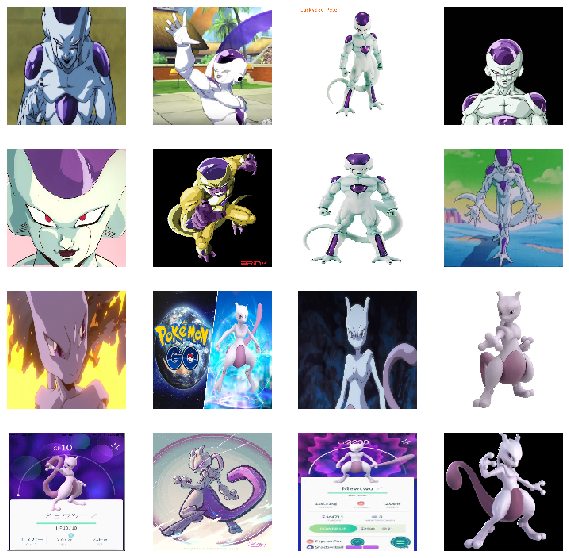

In [4]:
display_dir = './train/Freeza'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(8):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  plt.xticks([]),plt.yticks([])
  
display_dir = './train/Mewtoo'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

for i in range(8,16):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  plt.xticks([]),plt.yticks([])

plt.show()

上の図で、

上部分にフリーザ、下部分にミュウツーが見れると思います。８枚ずつしかありませんが、実際は２０枚ずつ以上あります。

次に、この画像データをCNNが学習しやすい形に変えていきます。

下のコードを実行してください。

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255)

valid_datagen = ImageDataGenerator(rescale = 1.0/255)

classes = {'Freeza','Mewtoo'}

batch_size = 4

train_generator = train_datagen.flow_from_directory(
    directory = 'train',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True)

valid_generator = valid_datagen.flow_from_directory(
    directory='valid',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size= batch_size,
    shuffle=True)

model = Mynet()

model.compile(loss = 'categorical_crossentropy',
             optimizer = SGD(lr = 1e-4, momentum = 0.9),
             metrics = ['accuracy'])

Found 46 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


画像データをCNNが学習させやすい形に変換できました。

次に、このデータを先程作ったCNNに読み込ませて、学習させていきます。

下のコードを実行すると、CNNを学習させることができます。epochsを変えれば、学習数を変えることができます。

In [6]:
epochs =20 #ここを変えれば学習数が変えられる

history = model.fit_generator(
    train_generator,
    steps_per_epoch= int((50-1)/batch_size) + 1,
    validation_data=valid_generator,
    validation_steps = int((20-1)/batch_size) + 1,
    epochs= epochs,
    initial_epoch = 0
    )

Epoch 1/20
13/13 [==============================] - 4s 344ms/step - loss: 0.7208 - acc: 0.5000 - val_loss: 0.7597 - val_acc: 0.5000
Epoch 2/20
13/13 [==============================] - 1s 69ms/step - loss: 0.7779 - acc: 0.4421 - val_loss: 0.8075 - val_acc: 0.5500
Epoch 3/20
13/13 [==============================] - 1s 68ms/step - loss: 0.6378 - acc: 0.7500 - val_loss: 0.6692 - val_acc: 0.4000
Epoch 4/20
13/13 [==============================] - 1s 68ms/step - loss: 0.5941 - acc: 0.6929 - val_loss: 0.6846 - val_acc: 0.5500
Epoch 5/20
13/13 [==============================] - 1s 64ms/step - loss: 0.6276 - acc: 0.5962 - val_loss: 0.8640 - val_acc: 0.6000
Epoch 6/20
13/13 [==============================] - 1s 72ms/step - loss: 0.6160 - acc: 0.6905 - val_loss: 0.7370 - val_acc: 0.5500
Epoch 7/20
13/13 [==============================] - 1s 65ms/step - loss: 0.6105 - acc: 0.6731 - val_loss: 0.6629 - val_acc: 0.4500
Epoch 8/20
13/13 [==============================] - 1s 79ms/step - loss: 0.5284 - 

学習が完了しました。

では、精度を見ていきましょう。

下のコードを実行すると、epochごとの正解率を見ることができます。

(0, 1)

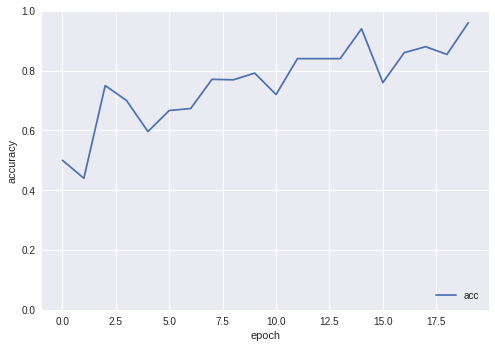

In [7]:
plt.plot(history.history["acc"])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc','val_acc'],loc = 'lower right')
plt.ylim(0,1)

上のグラフは学習しているときの、訓練データの正解率です。
横軸がepoch数(学習数)、縦軸が正解率です。

訓練データがきちんと判定できているか確かめます。
上の図で画像の上に書いてあるのが、CNNの判断したものです。
おそらく、訓練データの正解率はけっこう高いので、いい感じに当たっていると思います。

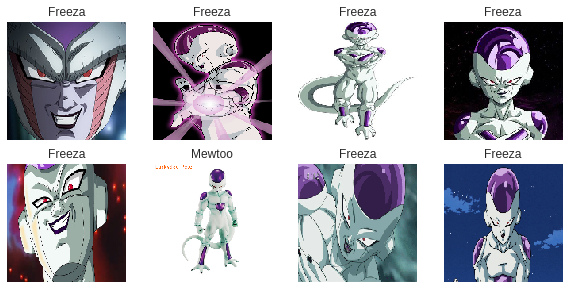

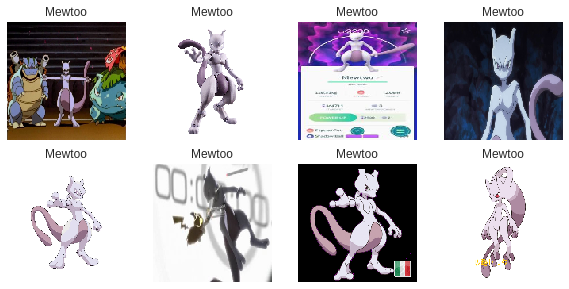

In [8]:
label = list(classes)
display_dir = './train/Freeza'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(8):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  temp_img_array=img_to_array(temp_img)
  temp_img_array=temp_img_array.astype('float32')/255.0
  temp_img_array=temp_img_array.reshape((1,150,150,3))
  img_pred=model.predict(temp_img_array)
  plt.title(label[np.argmax(img_pred)])
  plt.xticks([]),plt.yticks([])
  
display_dir = './train/Mewtoo'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(8):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  temp_img_array=img_to_array(temp_img)
  temp_img_array=temp_img_array.astype('float32')/255.0
  temp_img_array=temp_img_array.reshape((1,150,150,3))
  img_pred=model.predict(temp_img_array)
  plt.title(label[np.argmax(img_pred)])
  plt.xticks([]),plt.yticks([])

plt.show()

ですが、訓練データだけの正解率が高いだけでは、ただの訓練データだけを見分けられるCNNです。実際に精度を確かめるなら、訓練データに入れていない画像を用いて、検証する必要があります。そのためのデータを交差検証データといいます。

これから

交差検証データを見せ、

CNNによる交差検証データの精度が学習とともにどう変化しているか、

最後に交差検証データをCNNに判断させます。

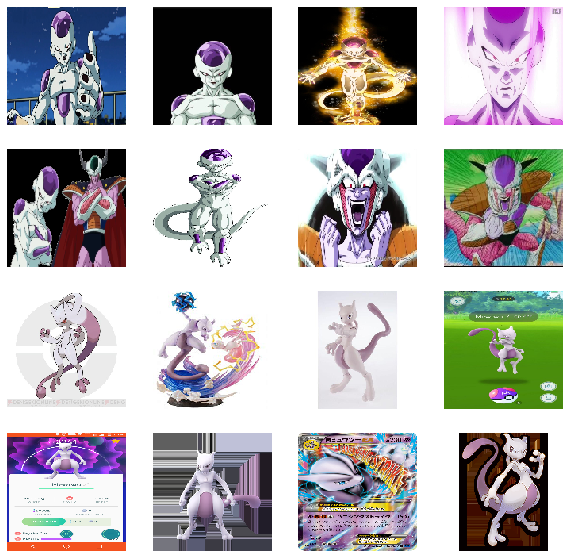

In [9]:
display_dir = './valid/Freeza'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(8):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  plt.xticks([]),plt.yticks([])
  
display_dir = './valid/Mewtoo'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

for i in range(8,16):
  temp_img=load_img(os.path.join(display_dir,img[i-8]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  plt.xticks([]),plt.yticks([])

plt.show()

このデータは訓練データに含まれていない交差検証データです。次は、CNNの交差検証データの正解率を学習とともに示したグラフです。


(0, 1)

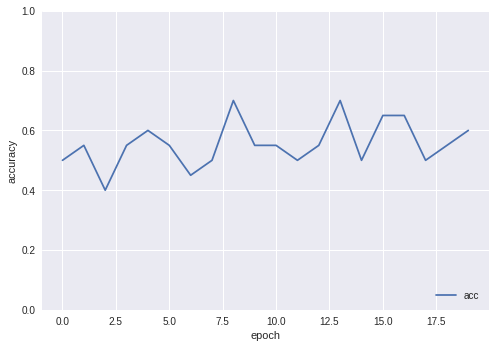

In [10]:
plt.plot(history.history["val_acc"])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc','val_acc'],loc = 'lower right')
plt.ylim(0,1)

訓練データよりかは良くないかったと思われます。
最後にこれをテストします。

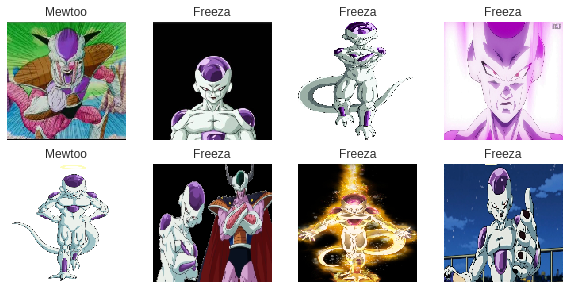

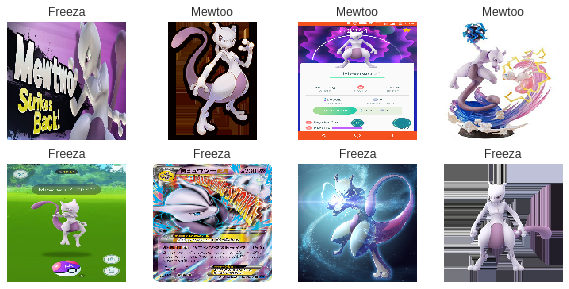

In [11]:
label = list(classes)
display_dir = './valid/Freeza'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(8):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  temp_img_array=img_to_array(temp_img)
  temp_img_array=temp_img_array.astype('float32')/255.0
  temp_img_array=temp_img_array.reshape((1,150,150,3))
  img_pred=model.predict(temp_img_array)
  plt.title(label[np.argmax(img_pred)])
  plt.xticks([]),plt.yticks([])
  
display_dir = './valid/Mewtoo'
files = os.listdir(display_dir)
img = random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(8):
  temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
  plt.subplot(4,4,i+1)
  plt.imshow(temp_img)
  temp_img_array=img_to_array(temp_img)
  temp_img_array=temp_img_array.astype('float32')/255.0
  temp_img_array=temp_img_array.reshape((1,150,150,3))
  img_pred=model.predict(temp_img_array)
  plt.title(label[np.argmax(img_pred)])
  plt.xticks([]),plt.yticks([])

plt.show()


おそらくあまりうまく行ってないと思います。

正直、この少ない時間で交差検証データの精度を上げるのは難しいです。交差検証データの精度を上げるためには時間をかける必要があります。だから、今回は訓練データをしっかりと判別させることはできましたが、まだ訓練データに含まれていない画像を判別させることはできないです。

ディープラーニングは交差検証データの正解率を上げることで、汎用性を上げています。交差検証データが上がれば、一般化ができたと言えるので大事です。

最後に、こちら側で構築した、交差検証データの正解率を上げたCNNを見せます。

IndexError: ignored

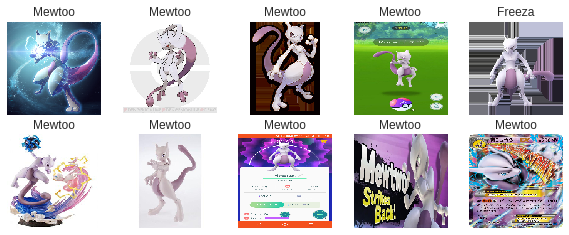

In [12]:
#load model and weights
json_string=open('model.json').read()
model=model_from_json(json_string)
model.load_weights('weight.h5')

model.compile(optimizer=SGD(lr=1e-4,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

display_dir = 'valid/Mewtoo'
#predict model and display images
files=os.listdir(display_dir)
img=random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(25):
    temp_img=load_img(os.path.join(display_dir,img[i]),target_size=(150,150))
    plt.subplot(5,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,150,150,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])


plt.show()